In [2]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #visualisation
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [3]:
from proj1_helpers import *
from zipfile import ZipFile

DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
with ZipFile('../data/train.csv.zip', 'r') as zip:
    zip.extractall('../data')
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [23]:
#Let's see the dimension of the input
print(tX.shape)
tX[:5]

(250000, 30)


array([[ 1.38470e+02,  5.16550e+01,  9.78270e+01,  2.79800e+01,
         9.10000e-01,  1.24711e+02,  2.66600e+00,  3.06400e+00,
         4.19280e+01,  1.97760e+02,  1.58200e+00,  1.39600e+00,
         2.00000e-01,  3.26380e+01,  1.01700e+00,  3.81000e-01,
         5.16260e+01,  2.27300e+00, -2.41400e+00,  1.68240e+01,
        -2.77000e-01,  2.58733e+02,  2.00000e+00,  6.74350e+01,
         2.15000e+00,  4.44000e-01,  4.60620e+01,  1.24000e+00,
        -2.47500e+00,  1.13497e+02],
       [ 1.60937e+02,  6.87680e+01,  1.03235e+02,  4.81460e+01,
        -9.99000e+02, -9.99000e+02, -9.99000e+02,  3.47300e+00,
         2.07800e+00,  1.25157e+02,  8.79000e-01,  1.41400e+00,
        -9.99000e+02,  4.20140e+01,  2.03900e+00, -3.01100e+00,
         3.69180e+01,  5.01000e-01,  1.03000e-01,  4.47040e+01,
        -1.91600e+00,  1.64546e+02,  1.00000e+00,  4.62260e+01,
         7.25000e-01,  1.15800e+00, -9.99000e+02, -9.99000e+02,
        -9.99000e+02,  4.62260e+01],
       [-9.99000e+02,  1.62172

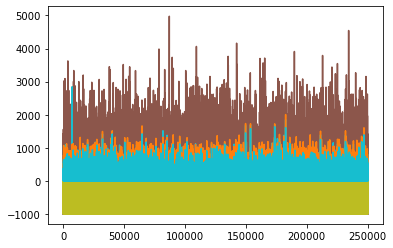

In [26]:
plt.plot(tX[1:])

## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [5]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
with ZipFile('../data/test.csv.zip', 'r') as zip:
    zip.extractall('../data')
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [6]:
OUTPUT_PATH = '../data/output.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

NameError: name 'weights' is not defined